In [1]:
import argparse
import logging
import sys

import numpy as np
import torch
from monai.transforms import AsDiscrete, MaskIntensity
from monai.utils import set_determinism
from torch.utils.tensorboard import SummaryWriter
import random
import os

import utils_parser
from reg_data import getRegistrationDataset
from reg_model import getRegistrationModel
from utils import compute_mean_dice, getAdamOptimizer, getReducePlateauScheduler, loadExistingModel, getDevice, compute_mean_dice
from utils import print_model_output, print_weights, add_weights_to_name, compute_landmarks_distance_local, compute_csv_distance
from loss import get_deformable_registration_loss_from_weights, get_affine_registration_loss_from_weights
import pandas as pd
import os
from glob import glob
from matplotlib import pyplot as plt
import monai
import torchinfo
from miseval import evaluate
from utils import apply_warp_to_landmarks_df, create_row_csv
import nibabel as nib

**Conventional metrics**

Landmarks

In [35]:
def get_barycentre(csvs): 
    df0 = pd.read_csv(csvs[0], sep=',', header=0)
    b_x = np.zeros(len(df0))
    b_y = np.zeros(len(df0))
    b_z = np.zeros(len(df0))
    for i, csv in enumerate(csvs):
        df = pd.read_csv(csv, sep=',', header=0)
        for j in range(len(df)):
            b_x[j] += df['x'][j]
            b_y[j] += df['y'][j]
            b_z[j] += df['z'][j]
    b_x /= len(csvs)
    b_y /= len(csvs)
    b_z /= len(csvs)
    
    barycentre_csv = pd.DataFrame()
    for i in range(len(b_x)):
        t = df0['t'][i]
        label = df0['label'][i]
        mass = df0['mass'][i]
        volume = df0['volume'][i]
        count = df0['count'][i]
        row = create_row_csv(b_x[i], b_y[i], b_z[i], t, label, mass, volume, count)
        temp_df = pd.DataFrame(data=row, index=[0])
        barycentre_csv = pd.concat([barycentre_csv, temp_df], ignore_index=True)
    return barycentre_csv

In [41]:
for dataset in ["Feminad"]:
    data_dir = os.path.join("/home/valentini/dev/Mousenet/dataset2/" + str(dataset) + "/")        
    landmarks_original_apply = sorted(glob(os.path.join("dataset2", "Feminad", "Landmarks_Resample_Identity", "*_antss.csv")))
    landmarks_original_apply_pos = sorted(glob(os.path.join("dataset2", "Feminad", "Landmarks_Resample_Identity", "*_scipy.csv")))
    landmarks_original_barycentre = get_barycentre(landmarks_original_apply)   
        
    landmarks_affine_apply = sorted(glob(os.path.join("dataset2", "Feminad", "Landmarks_Resample_Identity_Affine", "*_apply.csv")))
    landmarks_affine_apply_pos = sorted(glob(os.path.join("dataset2", "Feminad", "Landmarks_Resample_Identity_Affine", "*_apply_pos.csv")))
    landmarks_affine_barycentre = get_barycentre(landmarks_affine_apply)
    
    landmarks_ants_apply = sorted(glob(os.path.join("dataset2", "Feminad", "Landmarks_Resample_Identity_Affine_Deformable", "*_applytoapply.csv"))) 
             
    landmarks_ants_atlas = sorted(glob(os.path.join("dataset2", "Feminad", "Landmarks_Resample_Identity_Affine", "*_atlas_ants.csv"))) 
    landmarks_ants_barycentre = get_barycentre(landmarks_ants_atlas)
    
    landmarks_template_antss = os.path.join("dataset2", "Atlas", "Identity_Feminad_Template_Landmarks_antss.csv")
    landmarks_template_scipy = os.path.join("dataset2", "Atlas", "Identity_Feminad_Template_Landmarks_scipy.csv")
    
    mean_original = 0
    mean_affine = 0
    mean_ants   = 0
    mean_deep   = 0
    mean_ants_atlas = 0
    mean_deep_atlas = 0
    
    mean_original_barycentre = 0
    mean_affine_barycentre = 0
    mean_ants_barycentre = 0

    for i, landmark in enumerate(landmarks_affine_apply):
        print(i, end='\r')
        
        original_apply = compute_csv_distance(landmarks_original_apply[i], landmarks_template_antss)
        original_barycentre = compute_csv_distance(landmarks_original_apply[i], landmarks_original_barycentre)
        
        affine_apply = compute_csv_distance(landmarks_affine_apply[i], landmarks_template_antss)  
        affine_barycentre = compute_csv_distance(landmarks_affine_apply[i], landmarks_affine_barycentre)   
        
        ants_atlas = compute_csv_distance(landmarks_ants_atlas[i], landmarks_affine_apply[i])
        ants_barycentre = compute_csv_distance(landmarks_ants_atlas[i], landmarks_ants_barycentre)
                    
        mean_original += np.mean(original_apply[1:6])
        mean_affine += np.mean(affine_apply[1:6])
        mean_ants_atlas += np.mean(ants_atlas[1:6])
        
        mean_original_barycentre += np.mean(original_barycentre[1:6])
        mean_affine_barycentre += np.mean(affine_barycentre[1:6])
        mean_ants_barycentre += np.mean(ants_barycentre[1:6])
        
    print('-- Landmarks: --')
    print("No registration: {:.3f}".format(mean_original/len(landmarks_affine_apply)))
    print("Affine: {:.3f}".format(mean_affine/len(landmarks_affine_apply)))
    print("SyN: {:.3f}".format(mean_ants_atlas/len(landmarks_affine_apply)))
    
    print('-- Landmarks Barycentre: --')
    print("No registration: {:.3f}".format(mean_original_barycentre/len(landmarks_affine_apply)))
    print("Affine: {:.3f}".format(mean_affine_barycentre/len(landmarks_affine_apply)))
    print("SyN: {:.3f}".format(mean_ants_barycentre/len(landmarks_affine_apply)))
            

-- Landmarks: --
No registration: 4.313
Affine: 1.621
SyN: 1.179
-- Landmarks Barycentre: --
No registration: 4.282
Affine: 1.556
SyN: 1.054


Dices

In [8]:
template_mask = os.path.join("dataset2", "Atlas", "Identity_Feminad_Template_Mask.nii.gz")
template_mask = torch.from_numpy(nib.load(template_mask).get_fdata().reshape(1,128,128,128))
template_mask = AsDiscrete(threshold=0.5)(template_mask)
template_mask = template_mask.cpu().numpy().squeeze()
original_masks = sorted(glob(os.path.join("dataset2", "Feminad", "Mask_Resample_Identity", "*.nii.gz")))
affine_masks = sorted(glob(os.path.join("dataset2", "Feminad", "Mask_Resample_Identity_Affine", "*.nii.gz")))
ants_masks = sorted(glob(os.path.join("dataset2", "Feminad", "Mask_Resample_Identity_Deformable", "*.nii.gz")))


names = ["No registration", "Affine", "SyN"]
masks_lists = [original_masks, affine_masks, ants_masks]
dice = 0
hausdorf = 0
iou = 0
sens = 0
spec = 0
for z, masks_list in enumerate(masks_lists):
    for i in range(len(masks_list)):
        print(i, end='\r')
        mask = torch.from_numpy(nib.load(masks_list[i]).get_fdata().reshape(1,128,128,128))
        mask = AsDiscrete(threshold=0.5)(mask)
        mask = mask.cpu().numpy().squeeze()

        dice += evaluate(template_mask, mask, metric="DSC") 
        hausdorf += evaluate(template_mask, mask, metric="AHD")  
        iou += evaluate(template_mask, mask, metric="IoU")    
        sens += evaluate(template_mask, mask, metric="SENS")
        spec += evaluate(template_mask, mask, metric="SPEC")
    dice /= len(masks_list)
    hausdorf /= len(masks_list)
    iou /= len(masks_list)
    sens /= len(masks_list)
    spec /= len(masks_list)
    print(names[z])
    print(
        "Labels: Dice: {:.4f} / Haussdorf: {:.4f} / IoU: {:.4f} / Sens: {:.4f} / Spec: {:.4f}".format(
            dice, hausdorf, iou, sens, spec
        )
    )
    print('-'*20)

No registration
Labels: Dice: 0.8880 / Haussdorf: 10.6292 / IoU: 0.8002 / Sens: 0.8953 / Spec: 0.9818
--------------------
Affine
Labels: Dice: 0.9772 / Haussdorf: 8.7946 / IoU: 0.9299 / Sens: 0.9876 / Spec: 1.0205
--------------------
SyN
Labels: Dice: 0.9884 / Haussdorf: 8.5734 / IoU: 0.9495 / Sens: 0.9970 / Spec: 1.0233
--------------------


**Deep Learning Metrics**

In [2]:
z = 0
names = [
    "base-0.1",
    "base-8.0",
    "affine-0.1",
    "affine-8.0",
        ]
for modelname in [
        "paper/local_overfit_feminad_old_1.0-0.0-0.1.pth",
        "paper/local_overfit_feminad_old_1.0-0.0-8.0.pth",
        "paper/local_overfit_feminad_old_affine_1.0-0.0-0.1.pth",
        "paper/local_overfit_feminad_old_affine_1.0-0.0-8.0.pth",
]:
    dataset = "feminadaffine"
    batchsize = 1
    registration_type = "local"
    atlas=True
    mask=False
    torch.multiprocessing.set_sharing_strategy('file_system')
    torch.backends.cudnn.benchmark = True
    
    set_determinism(seed=0)
    logging.basicConfig(stream=sys.stdout, level=logging.INFO)
    device = getDevice()
    
    
    if "ddf" in modelname:
        use_ddf = True
    else:
        use_ddf = False
    if "newmodel" in modelname:
        model = getRegistrationModel(registration_type, img_size=128, channels=32, extract=[0,1,2,3,4], use_ddf=use_ddf)
        #print(model.summary())
    else:
        model = getRegistrationModel(registration_type, img_size=128, channels=16, extract=[0,1,2,3], use_ddf=use_ddf)
    weights = loadExistingModel(model, None, ft=modelname, registration=True)
    model.eval()

    dataloaders, size = getRegistrationDataset(dataset=dataset,
                                               batch=batchsize,
                                               training=False,
                                               augment=False,
                                               eval_augment=False,
                                               atlas=atlas,
                                               mask=mask,
                                               )

    running_loss = 0.0
    
    running_dice = 0.0
    running_hausdorf = 0.0
    running_iou = 0.0
    running_sens = 0.0
    running_spec = 0.0
    
    running_meanl = 0.0
    running_maxl = 0.0
    running_minl = 0.0
    
    running_meanbary = 0.0
    
    phase="test"
    
    mouses_df = pd.DataFrame()
    with torch.no_grad():
        pred_image_csvs = []
        for i, data in enumerate(dataloaders[phase]):
            print(i, end='\r')
            with torch.set_grad_enabled(phase == 'train'):
                rtype = registration_type.lower()
                if rtype == 'affine' or rtype == 'local':
                    ddf, pred_image, pred_label, _ = model(data)
                elif rtype == 'deformable':
                    affine_ddf, ddf, pred_image, pred_label, affine_image, affine_label = model(data)

                pred_image = pred_image.to(device, non_blocking=True)
                pred_label = pred_label.to(device, non_blocking=True)
                pred_mask = AsDiscrete(threshold=0.5)(pred_label)

                fixed_image = data['fixed_image'].to(device, non_blocking=True)
                fixed_label = data['fixed_label'].to(device, non_blocking=True)
                fixed_mask = AsDiscrete(threshold=0.5)(fixed_label)
                
                
                weights = [1, 0, 1] # to compare loss between methods
                img_loss, lbl_loss, ddf_loss = get_deformable_registration_loss_from_weights(pred_image, pred_label,
                                                                                                 fixed_image, fixed_label,
                                                                                                 ddf, weights)
                loss = img_loss + lbl_loss + ddf_loss
                
                ##################################
                distances = compute_landmarks_distance_local(ddf, data)
                
                
                ddf = ddf.permute(2,3,4,0,1)
                cwd = os.path.abspath("/home/valentini/dev/Mousenet/")
                affine_csv_dir = os.path.join(cwd, "dataset2", "Feminad", "Landmarks_Resample_Identity_Affine")
                mri_name = data['moving_image_meta_dict']['filename_or_obj'][0]
                mri_name = mri_name.split('.')[0].split('_')

                moving_image_csv = affine_csv_dir + "/Affine_Identity_Landmarks_" + mri_name[-2] + '_' + mri_name[-1] + '_apply_pos.csv'
                fixed_image_csv = os.path.join(cwd, "dataset2", "Atlas", "Identity_Feminad_Template_Landmarks_scipy.csv")
                pred_image_csv = apply_warp_to_landmarks_df(fixed_image_csv, ddf)  
                pred_image_csvs.append(pred_image_csv)
                
                
                pred_mask_np = pred_mask.cpu().numpy().squeeze()
                fixed_mask_np = fixed_mask.cpu().numpy().squeeze()
                
                dice = evaluate(fixed_mask_np, pred_mask_np, metric="DSC")   
                hausdorf = evaluate(fixed_mask_np, pred_mask_np, metric="AHD")  
                iou = evaluate(fixed_mask_np, pred_mask_np, metric="IoU")    
                sens = evaluate(fixed_mask_np, pred_mask_np, metric="SENS")
                spec = evaluate(fixed_mask_np, pred_mask_np, metric="SPEC")
                
                #mean_landmark = np.mean(distances[0:6])
                mean_landmark = np.mean(distances[1:6])
                max_landmark = np.max(distances[1:6])
                min_landmark = np.min(distances[1:6])
                ##################################      

            running_loss += loss.item() * fixed_image.size(0)
            
            running_dice += dice.item() * fixed_image.size(0)
            running_hausdorf += hausdorf.item() * fixed_image.size(0)
            running_iou  += iou.item() * fixed_image.size(0)
            running_sens += sens.item() * fixed_image.size(0)
            running_spec += spec.item() * fixed_image.size(0)
            
            running_meanl += mean_landmark.item() * fixed_image.size(0)
            running_maxl += max_landmark.item() * fixed_image.size(0)
            running_minl += min_landmark.item() * fixed_image.size(0)
            
            row = {
                    'mouse': data['moving_image_meta_dict']['filename_or_obj'][0].split('/')[-1],
                    'distance1_'+str(names[z]): distances[0],
                    'distance2_'+str(names[z]): distances[1],
                    'distance3_'+str(names[z]): distances[2],
                    'distance4_'+str(names[z]): distances[3],
                    'distance5_'+str(names[z]): distances[4],
                    'distance6_'+str(names[z]): distances[5],
                    'meantre_'+str(names[z]): mean_landmark,
                    'dsc_'+str(names[z]): dice,
                    'ahd_'+str(names[z]): hausdorf,
                    'iou_'+str(names[z]): iou,
                    'sens_'+str(names[z]): sens,
                    'spec_'+str(names[z]): spec,
            }
            mouse_df = pd.DataFrame(data=row, index=[0])
            mouses_df = pd.concat([mouses_df, mouse_df], ignore_index=True)
            
        barycentre_csv = pd.DataFrame()
        for i in range(len(pred_image_csvs[0])):
            b_x = np.zeros(len(pred_image_csvs[0]))
            b_y = np.zeros(len(pred_image_csvs[0]))
            b_z = np.zeros(len(pred_image_csvs[0]))
            for csv in pred_image_csvs:
                b_x[i] += csv['x'][i]
                b_y[i] += csv['y'][i]
                b_z[i] += csv['z'][i]
            b_x[i] /= len(pred_image_csvs)
            b_y[i] /= len(pred_image_csvs)
            b_z[i] /= len(pred_image_csvs)
                
                
            t = pred_image_csvs[0]['t'][i]
            label = pred_image_csvs[0]['label'][i]
            mass = pred_image_csvs[0]['mass'][i]
            volume = pred_image_csvs[0]['volume'][i]
            count = pred_image_csvs[0]['count'][i]
                
            row = create_row_csv(b_x[i], b_y[i], b_z[i], t, label, mass, volume, count)
            temp_df = pd.DataFrame(data=row, index=[0])
            barycentre_csv = pd.concat([barycentre_csv, temp_df], ignore_index=True)
            
             
        for i, data in enumerate(dataloaders[phase]):
            print(i, end='\r')
            if rtype == 'affine' or rtype == 'local':
                ddf, pred_image, pred_label, _ = model(data)
            elif rtype == 'deformable':
                affine_ddf, ddf, pred_image, pred_label, affine_image, affine_label = model(data)
                
            pred_image = pred_image.to(device, non_blocking=True)
            pred_label = pred_label.to(device, non_blocking=True)
            pred_mask = AsDiscrete(threshold=0.5)(pred_label)

            fixed_image = data['fixed_image'].to(device, non_blocking=True)
            fixed_label = data['fixed_label'].to(device, non_blocking=True)
            fixed_mask = AsDiscrete(threshold=0.5)(fixed_label)                
                
            ddf = ddf.permute(2,3,4,0,1)

            cwd = os.path.abspath("/home/valentini/dev/Mousenet/")
            affine_csv_dir = os.path.join(cwd, "dataset2", "Feminad", "Landmarks_Resample_Identity_Affine")
            mri_name = data['moving_image_meta_dict']['filename_or_obj'][0]
            mri_name = mri_name.split('.')[0].split('_')

            fixed_image_csv = os.path.join(cwd, "dataset2", "Atlas", "Identity_Feminad_Template_Landmarks_scipy.csv")
            pred_image_csv = apply_warp_to_landmarks_df(fixed_image_csv, ddf)
            distances = compute_csv_distance(barycentre_csv, pred_image_csv)
            
            mean_bary = np.mean(distances)
            running_meanbary += mean_bary.item()


    sizelol = 33    
    running_loss /= sizelol
    running_dice /= sizelol
    running_hausdorf /= sizelol
    running_iou /= sizelol
    running_sens /= sizelol
    running_spec /= sizelol
    running_meanl /= sizelol
    running_maxl /= sizelol
    running_minl /= sizelol
    running_meanbary /= sizelol
    #print(modelname)
    print(names[z])
    print(
        "Loss: loss: {:.4f}".format(
            running_loss, 
        )
    )
    print(
        "Labels: Dice: {:.4f} / Haussdorf: {:.4f} / IoU: {:.4f} / Sens: {:.4f} / Spec: {:.4f}".format(
            running_dice, running_hausdorf, running_iou, running_sens, running_spec
        )
    )
    print(
        "Landmarks: Mean: {:.4f} / Max: {:.4f} / Min: {:.4f}".format(
            running_meanl, running_maxl, running_minl, 
        )
    )
    print(
        "Landmarks Barycenter: Mean: {:.4f}".format(
            running_meanbary,
        )
    )
    
    #print(mouses_df)
    mouses_df.to_csv("models/" + modelname.split('/')[-1].split('.pth')[0] + '.csv', index=False)
    print('-'*20)    
    z += 1

monai.networks.blocks.Warp: Using PyTorch native grid_sample.


=> Using Feminad affine registered dataset.


Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 388797.84it/s]


monai.networks.blocks.Warp: Using PyTorch native grid_sample.


base-0.1
Loss: loss: 0.1401
Labels: Dice: 0.9709 / Haussdorf: 8.0573 / IoU: 0.9437 / Sens: 0.9671 / Spec: 0.9962
Landmarks: Mean: 1.3358 / Max: 2.3629 / Min: 0.6060
Landmarks Barycenter: Mean: 0.9387
--------------------
=> Using Feminad affine registered dataset.


Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 109243.91it/s]


monai.networks.blocks.Warp: Using PyTorch native grid_sample.


base-8.0
Loss: loss: 0.1390
Labels: Dice: 0.9589 / Haussdorf: 8.4820 / IoU: 0.9215 / Sens: 0.9729 / Spec: 0.9914
Landmarks: Mean: 1.2353 / Max: 2.1447 / Min: 0.6253
Landmarks Barycenter: Mean: 1.0061
--------------------
=> Using Feminad affine registered dataset.


Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 378174.95it/s]


monai.networks.blocks.Warp: Using PyTorch native grid_sample.


affine-0.1
Loss: loss: 0.1492
Labels: Dice: 0.9740 / Haussdorf: 7.4006 / IoU: 0.9494 / Sens: 0.9682 / Spec: 0.9970
Landmarks: Mean: 1.3451 / Max: 2.3593 / Min: 0.5665
Landmarks Barycenter: Mean: 0.9929
--------------------
=> Using Feminad affine registered dataset.


Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 159277.37it/s]


affine-8.0
Loss: loss: 0.1339
Labels: Dice: 0.9591 / Haussdorf: 8.5658 / IoU: 0.9219 / Sens: 0.9748 / Spec: 0.9911
Landmarks: Mean: 1.2158 / Max: 2.1326 / Min: 0.6025
Landmarks Barycenter: Mean: 1.0335
--------------------


In [19]:
# create original distance csvs
atlas_csv = os.path.join("dataset2", "Atlas", "Identity_Feminad_Template_Landmarks_antss.csv")
original_csvs = sorted(glob(os.path.join("dataset2", "Feminad", "Landmarks_Resample_Identity", "*_antss.csv")))

names = [
            "Affine_Identity_Norm_Resampled_N4_12_6517.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_12_6518.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_12_6519.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_12_6522.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_12_6523.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_12_6524.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_12_6528.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_12_6529.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_12_6533.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_12_6535.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_12_6536.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_12_6538.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_12_6626.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6516.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6517.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6518.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6519.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6520.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6521.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6522.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6523.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6524.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6528.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6529.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6533.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6535.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6536.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6537.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6538.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6539.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6540.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6541.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6542.nii.gz",
        ]

mouses_df = pd.DataFrame()
for i, original_csv in enumerate(original_csvs):
    distances = compute_csv_distance(original_csv, atlas_csv)
    row = {
        'mouse': names[i],
        'distance1_original': distances[0],
        'distance2_original': distances[1],
        'distance3_original': distances[2],
        'distance4_original': distances[3],
        'distance5_original': distances[4],
        'distance6_original': distances[5],
        'meantre_original': np.mean(distances[1:6]),
    }
    mouse_df = pd.DataFrame(data=row, index=[0])
    mouses_df = pd.concat([mouses_df, mouse_df], ignore_index=True)
mouses_df.to_csv("models/template_original.csv", index=False)

In [20]:
# create affine + ants distance csvs
atlas_csv = os.path.join("dataset2", "Atlas", "Identity_Feminad_Template_Landmarks_antss.csv")
ants_csvs = sorted(glob(os.path.join("dataset2", "Feminad", "Landmarks_Resample_Identity_Affine", "*_atlas_ants.csv")))
affine_csvs = sorted(glob(os.path.join("dataset2", "Feminad", "Landmarks_Resample_Identity_Affine", "*_apply.csv")))

names = [
            "Affine_Identity_Norm_Resampled_N4_12_6517.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_12_6518.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_12_6519.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_12_6522.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_12_6523.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_12_6524.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_12_6528.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_12_6529.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_12_6533.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_12_6535.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_12_6536.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_12_6538.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_12_6626.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6516.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6517.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6518.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6519.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6520.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6521.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6522.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6523.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6524.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6528.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6529.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6533.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6535.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6536.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6537.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6538.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6539.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6540.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6541.nii.gz",
            "Affine_Identity_Norm_Resampled_N4_2_6542.nii.gz",
        ]

mouses_df = pd.DataFrame()
for i, affine_csv in enumerate(affine_csvs):
    distances = compute_csv_distance(affine_csv, atlas_csv)
    row = {
        'mouse': names[i],
        'distance1_affine': distances[0],
        'distance2_affine': distances[1],
        'distance3_affine': distances[2],
        'distance4_affine': distances[3],
        'distance5_affine': distances[4],
        'distance6_affine': distances[5],
        'meantre_affine': np.mean(distances[1:6]),
    }
    mouse_df = pd.DataFrame(data=row, index=[0])
    mouses_df = pd.concat([mouses_df, mouse_df], ignore_index=True)
mouses_df.to_csv("models/template_affine.csv", index=False)


mouses_df = pd.DataFrame()
for i, ants_csv in enumerate(ants_csvs):
    distances = compute_csv_distance(affine_csvs[i], ants_csvs[i])
    row = {
        'mouse': names[i],
        'distance1_ants': distances[0],
        'distance2_ants': distances[1],
        'distance3_ants': distances[2],
        'distance4_ants': distances[3],
        'distance5_ants': distances[4],
        'distance6_ants': distances[5],
        'meantre_ants': np.mean(distances[1:6]),
    }
    mouse_df = pd.DataFrame(data=row, index=[0])
    mouses_df = pd.concat([mouses_df, mouse_df], ignore_index=True)
mouses_df.to_csv("models/template_ants.csv", index=False)


In [29]:
csvs = sorted(glob(os.path.join("models", "*.csv")))
new_df = pd.DataFrame()
for i, csv in enumerate(csvs):
    df = pd.read_csv(csv, sep=',', header=0)
    if i==0:
        new_df = df
    else:
        new_df = pd.merge(new_df,df,on='mouse')
new_df.to_csv("models/bigcsv2.csv", index=False)

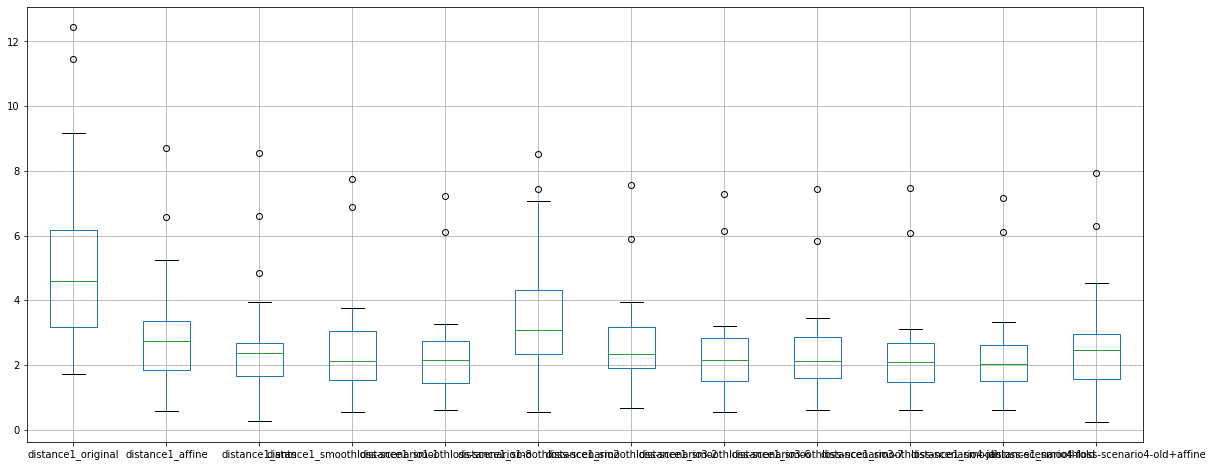

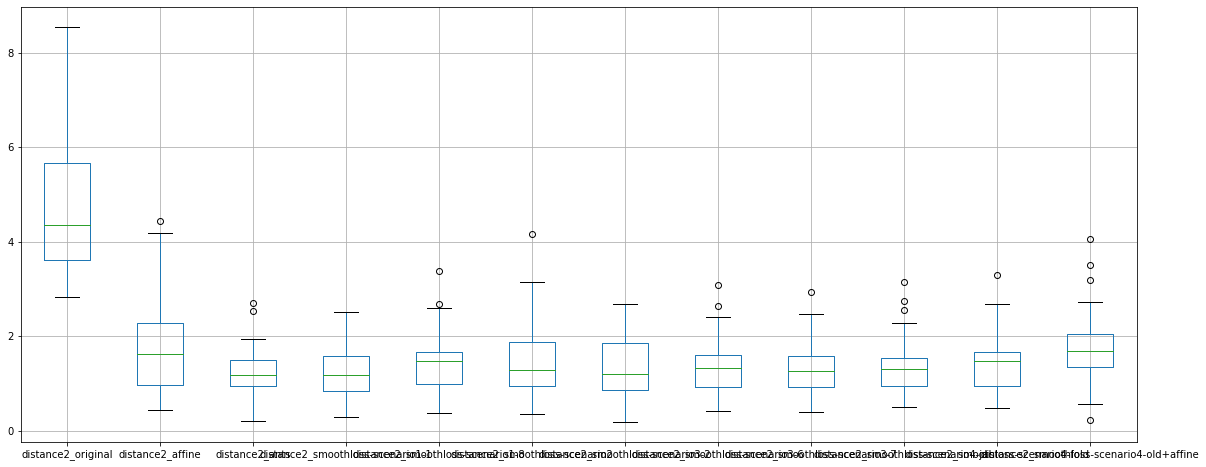

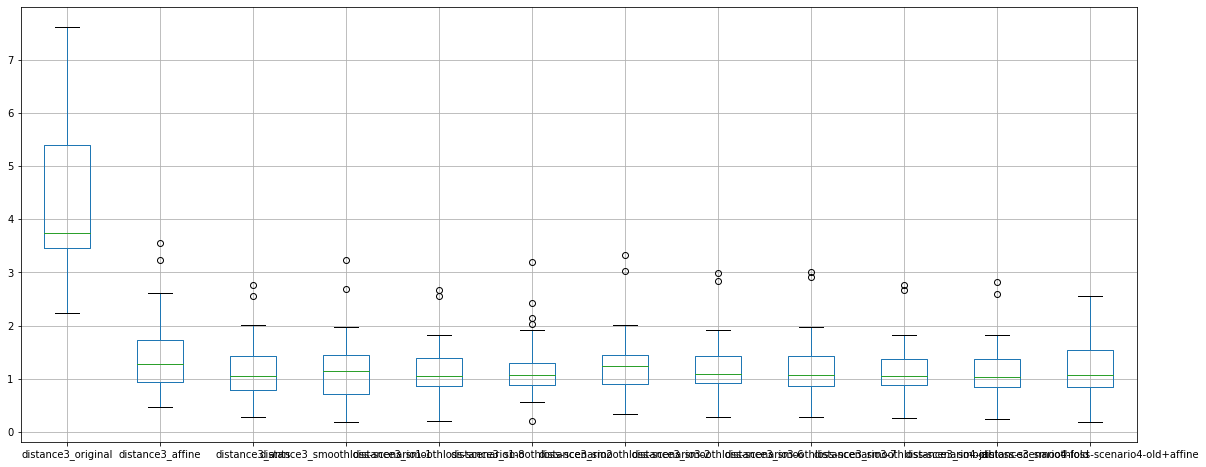

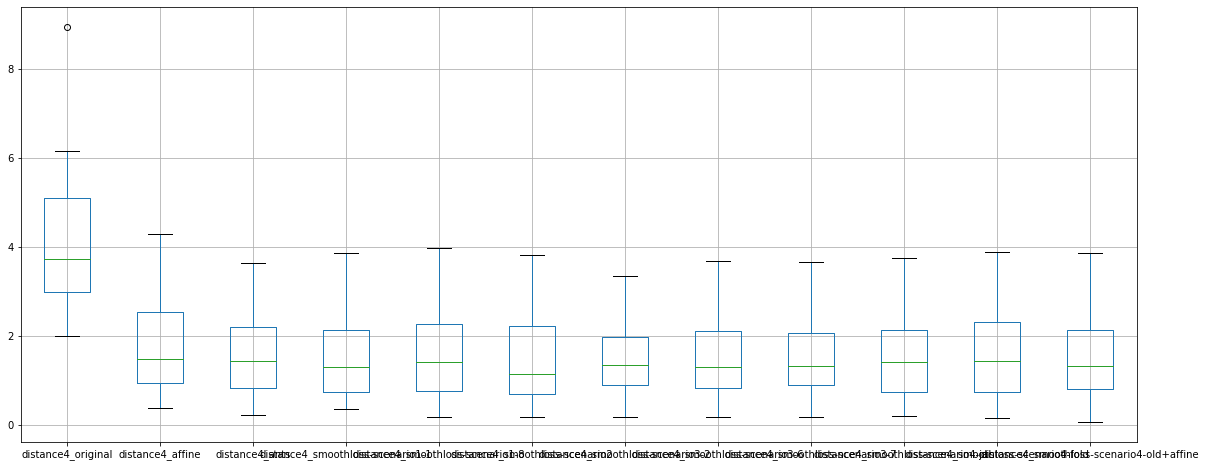

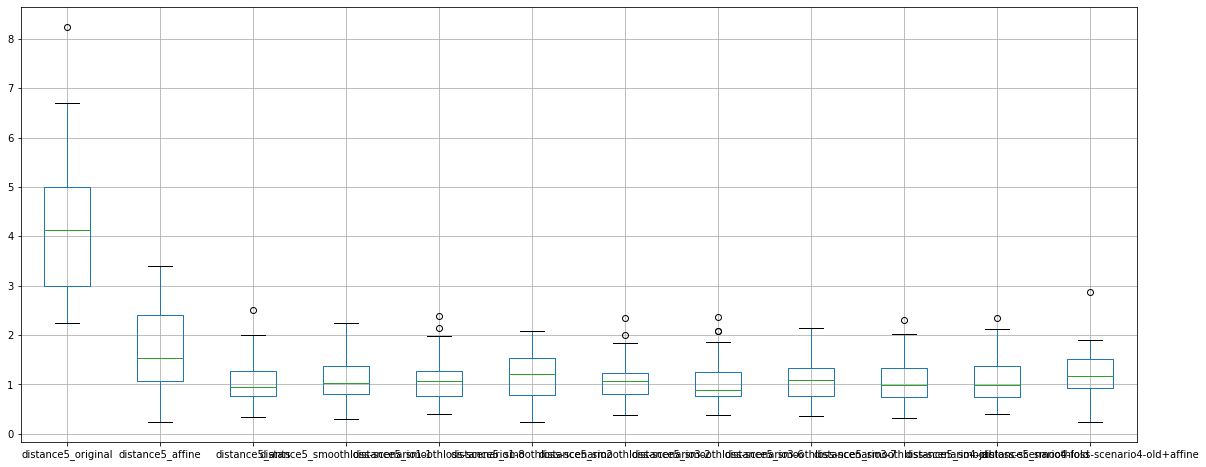

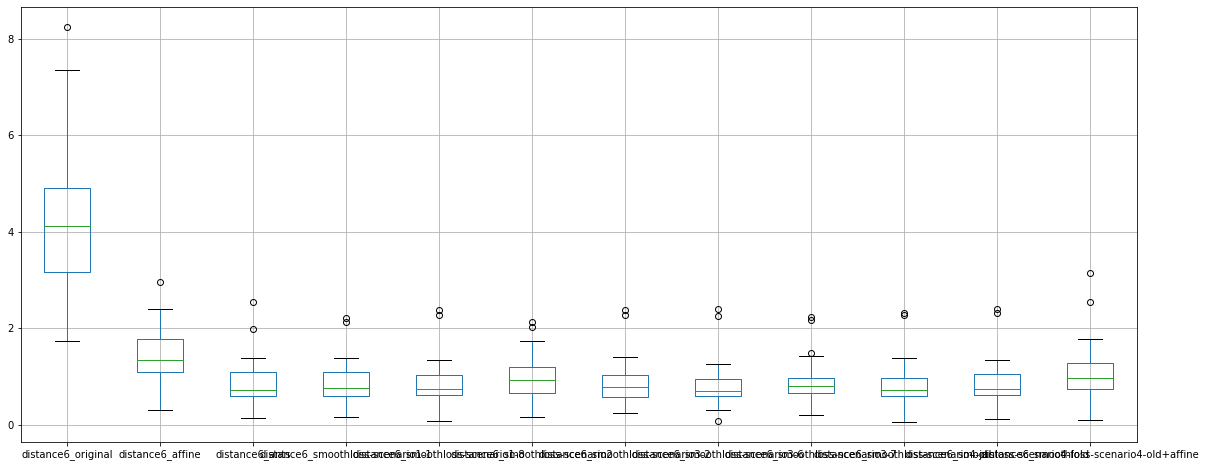

In [30]:
names = [
        "original",
        "affine",
        "ants",
        "smoothloss-scenario1-1",
        "smoothloss-scenario1-8",
        "smoothloss-scenario2",
        "smoothloss-scenario3-2",
        "smoothloss-scenario3-6",
        "smoothloss-scenario3-7",
        "smoothloss-scenario4-jac",
        "smoothloss-scenario4-fold",
        "smoothloss-scenario4-old+affine",
        ]

for i in range(1, 7):
    columns = ["distance" + str(i) + "_" + z for z in names]
    b_plot = new_df.boxplot(figsize=(20,8),column = columns) 
    plt.show()

